In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy

# function to count number of parameters
def get_n_params(model):
    np=0
    for p in list(model.parameters()):
        np += p.nelement()
    return np

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


In [2]:
input_size  = 28*28   # images are 28x28 pixels
output_size = 10      # there are 10 classes

train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=64, shuffle=True)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=1000, shuffle=True)

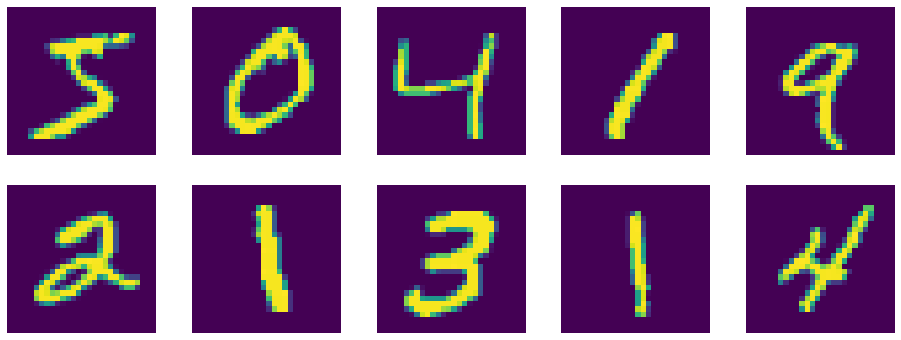

In [3]:
# show some images
plt.figure(figsize=(16, 6))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    image, _ = train_loader.dataset.__getitem__(i)
    plt.imshow(image.squeeze().numpy())
    plt.axis('off');

In [4]:
class CNN(nn.Module):
    def __init__(self, input_size, n_feature, output_size):
        super(CNN, self).__init__()
        self.n_feature = n_feature
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=n_feature, kernel_size=5)
        self.conv2 = nn.Conv2d(n_feature, n_feature, kernel_size=5)
        self.fc1 = nn.Linear(n_feature*4*4, 50)
        self.fc2 = nn.Linear(50, 10)
        
    def forward(self, x, verbose=False):
        x = self.conv1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)
        x = x.view(-1, self.n_feature*4*4)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.log_softmax(x, dim=1)
        return x

In [5]:

accuracy_list = []

def train(epoch, model, perm=torch.arange(0, 784).long()):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        # send to device
        data, target = data.to(device), target.to(device)
        
        # permute pixels
        data = data.view(-1, 28*28)
        data = data[:, perm]
        data = data.view(-1, 1, 28, 28)

        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))


def test(model, perm=torch.arange(0, 784).long()):
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        # send to device
        data, target = data.to(device), target.to(device)
        
        # permute pixels
        data = data.view(-1, 28*28)
        data = data[:, perm]
        data = data.view(-1, 1, 28, 28)
        output = model(data)
        test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss                                                               
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability                                                                 
        correct += pred.eq(target.data.view_as(pred)).cpu().sum().item()

    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)
    accuracy_list.append(accuracy)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        accuracy))

In [6]:
# Training settings 
n_features = 6 # number of feature maps
model_cnn = CNN(input_size, n_features, output_size)
model_cnn.to(device)
optimizer = optim.SGD(model_cnn.parameters(), lr=0.01, momentum=0.5)
print('Number of parameters: {}'.format(get_n_params(model_cnn)))

for epoch in range(0, 1):
    train(epoch, model_cnn)
    test(model_cnn)

Number of parameters: 6422
Train Epoch: 0 [0/60000 (0%)]	Loss: 2.310651
Train Epoch: 0 [6400/60000 (11%)]	Loss: 2.210916
Train Epoch: 0 [12800/60000 (21%)]	Loss: 0.520111
Train Epoch: 0 [19200/60000 (32%)]	Loss: 0.531560
Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.739905
Train Epoch: 0 [32000/60000 (53%)]	Loss: 0.299389
Train Epoch: 0 [38400/60000 (64%)]	Loss: 0.189821
Train Epoch: 0 [44800/60000 (75%)]	Loss: 0.271498
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.093608
Train Epoch: 0 [57600/60000 (96%)]	Loss: 0.163395

Test set: Average loss: 0.1981, Accuracy: 9395/10000 (94%)



In [7]:
import numpy as np

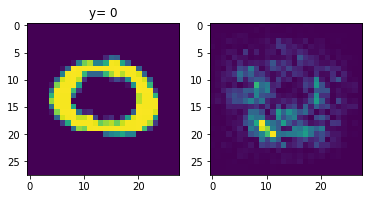

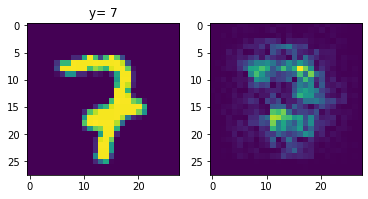

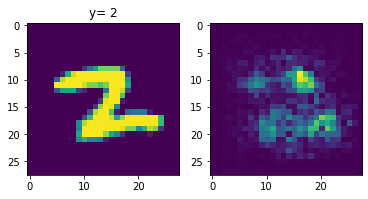

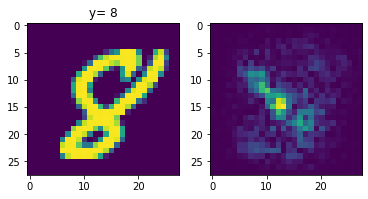

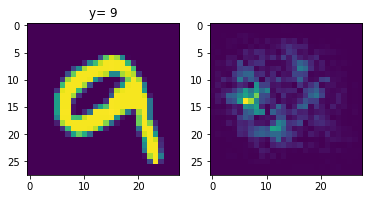

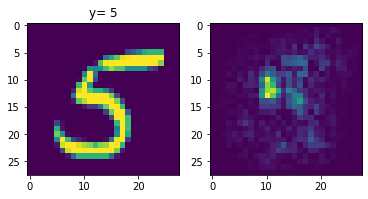

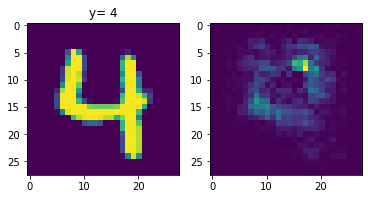

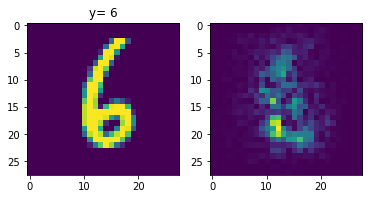

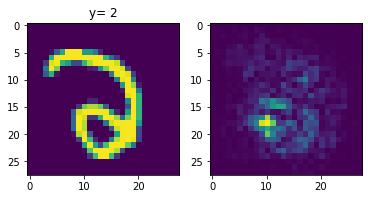

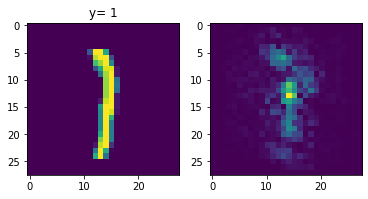

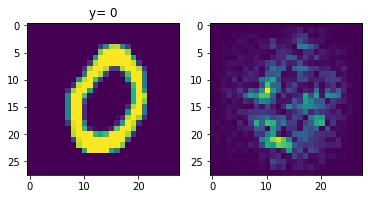

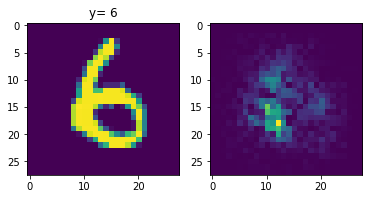

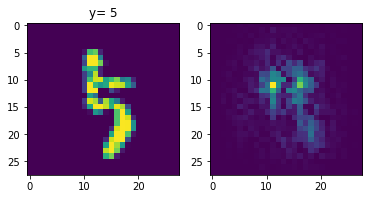

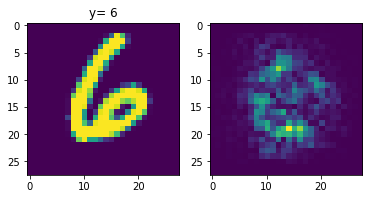

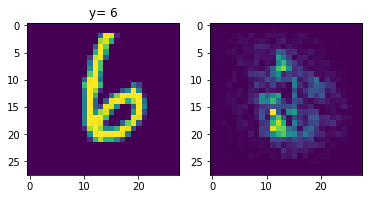

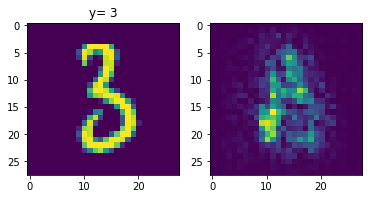

In [9]:
# testing
model_cnn.eval()
for i in range(16):
    for x,y in test_loader:
       #break
        #with torch.no_grad():
        x = x[i].resize(1,1,28,28).to(device)
        y = y[i].to(device)
        #break

        x.requires_grad_()
        y_NN = model_cnn(x)
        y_NN = y_NN[:,y_NN.argmax()]
        y_NN.backward()
        #loss = F.nll_loss(y_NN, y)

        saliency = (x.grad[0,0]).cpu().detach().numpy()
        x = (x[0,0]).cpu().detach().numpy()

     #   print(y.cpu().detach().numpy(), y_NN.cpu().detach().numpy())
       # print('loss = %.3e'%loss)
       # print(x.shape)
       # print(saliency.shape)

        #np.save('image3.npy',x)
       # np.save(f_map_out, saliency)
        plt.figure()
        plt.subplot(121)
        plt.imshow(x)
        plt.title('y= ' + str(y.item()))
        plt.subplot(122)
        plt.imshow(abs(saliency))
        break